## Super resolution

In [1]:
from fastai.vision.all import *
import torch
import time

In [2]:
DATASET_PATH = Path('/home/lleonard/Documents/datasets/best_art/images/512px/')
RESIZED_PATH = Path('/home/lleonard/Documents/datasets/best_art/images/96px/')

In [3]:
bs,size=32,128
arch = resnet50

In [4]:
def get_y(file_path):
    return DATASET_PATH / file_path.parent.relative_to(RESIZED_PATH) / file_path.name

def get_dls(bs,size):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y=get_y,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(), Normalize()])
    dblock.summary(RESIZED_PATH)
    dls = dblock.dataloaders(RESIZED_PATH, bs=bs)         
    dls.c = 3
    return dls

In [5]:
dls = get_dls(bs,size)

Setting-up type transforms pipelines
Found 8774 items
2 datasets of sizes 7020,1754
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/lleonard/Documents/datasets/best_art/images/96px/Pablo_Picasso/Pablo_Picasso_241.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=65x96
  Pipeline: get_y -> PILBase.create
    starting from
      /home/lleonard/Documents/datasets/best_art/images/96px/Pablo_Picasso/Pablo_Picasso_241.jpg
    applying get_y gives
      /home/lleonard/Documents/datasets/best_art/images/512px/Pablo_Picasso/Pablo_Picasso_241.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=345x512

Final sample: (PILImage mode=RGB size=65x96, PILImage mode=RGB size=345x512)


Found 8774 items
2 datasets of sizes 7020,1754
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: Resize -- {'size'

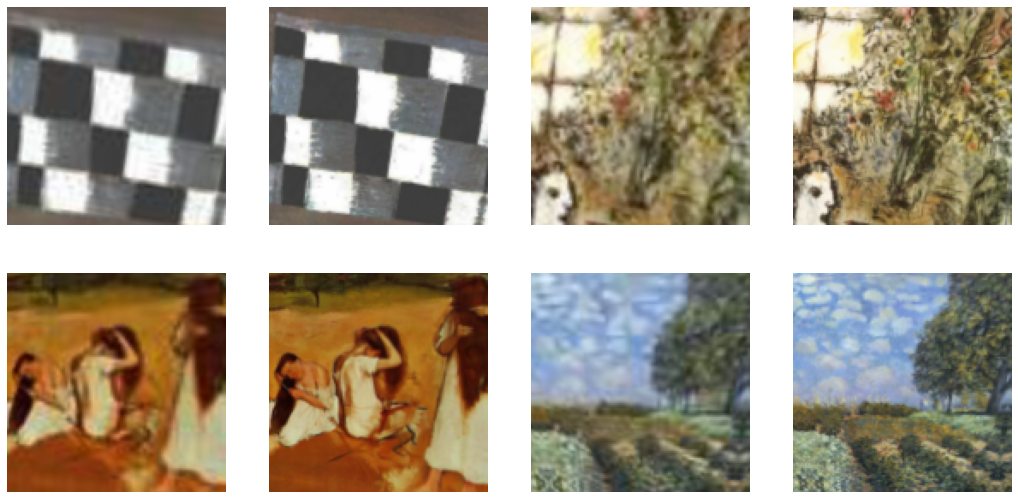

In [6]:
dls.train.show_batch(max_n=4, figsize=(18,9))

## Feature loss

In [7]:
t = tensor(dls.valid_ds[0][1]).float().permute(2,0,1)/255.
t = torch.stack([t,t])

In [8]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [9]:
t.shape

torch.Size([2, 3, 512, 419])

In [10]:
gram_matrix(t)

tensor([[[0.0288, 0.0241, 0.0163],
         [0.0241, 0.0206, 0.0140],
         [0.0163, 0.0140, 0.0099]],

        [[0.0288, 0.0241, 0.0163],
         [0.0241, 0.0206, 0.0140],
         [0.0163, 0.0140, 0.0099]]])

In [11]:
base_loss = F.l1_loss

In [12]:
data = torch.load('./models/paintings_artist_classifier.pth')
vgg_m = data[0][0].eval()

In [13]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [14]:
class FeatureLoss(Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        self.m_feat = m_feat
        self.loss_features = [m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target,reduction=reduction)]
        self.feat_losses += [base_loss(f_in, f_out,reduction=reduction)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out),reduction=reduction)*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        if reduction=='none': 
            self.feat_losses = [f.mean(dim=[1,2,3]) for f in self.feat_losses[:4]] + [f.mean(dim=[1,2]) for f in self.feat_losses[4:]]
        for n,l in zip(self.metric_names, self.feat_losses): setattr(self, n, l)
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [15]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [16]:
learn = unet_learner(dls, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                     blur=True, norm_type=NormType.Spectral, self_attention=True)

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.0012022644514217973)

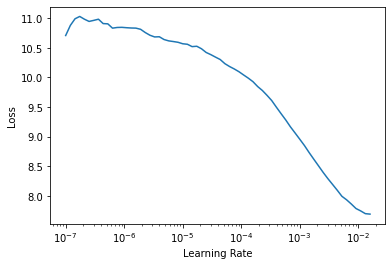

In [17]:
learn.lr_find()

In [18]:
lr = 3e-3
wd = 1e-3

In [19]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start, wd=wd)
    learn.save(save_name)
    learn.show_results(max_n=2, figsize=(15,11))

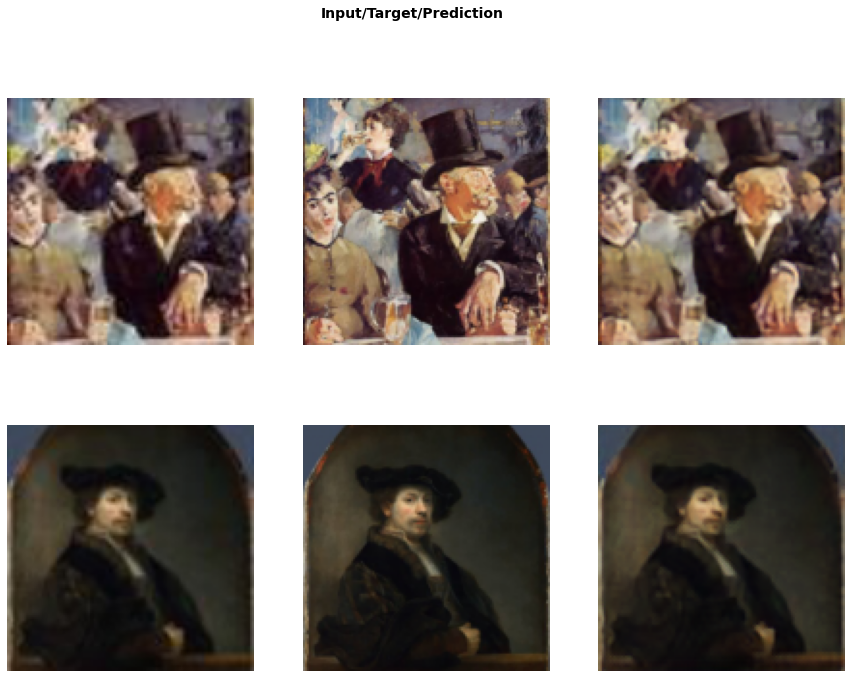

In [20]:
do_fit('super_res_painting_vgg_loss', slice(lr*10))

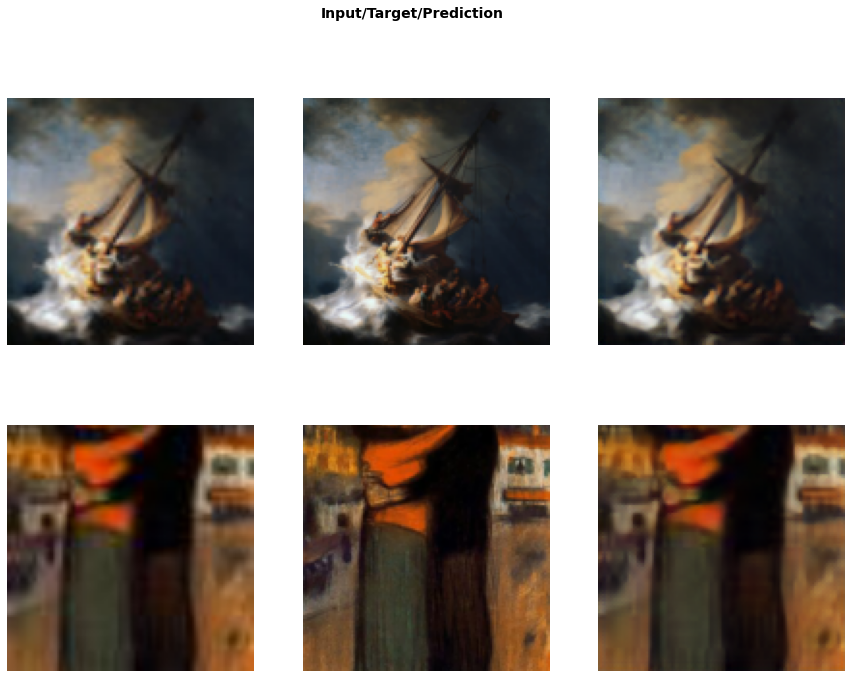

In [21]:
learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

In [22]:
print(bad)

NameError: name 'bad' is not defined

In [24]:
learn.unfreeze()

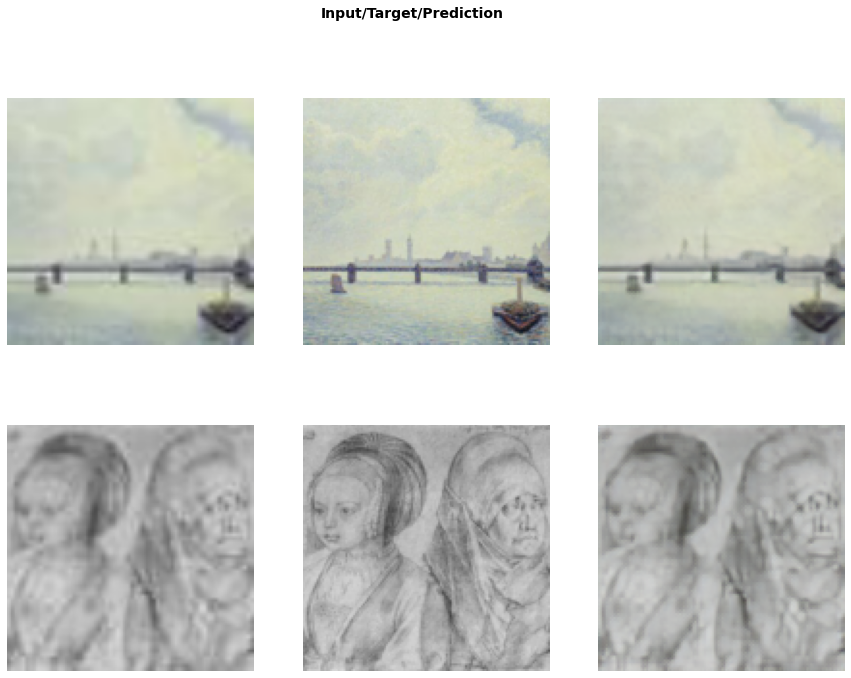

In [25]:
do_fit('super_res_painting_vgg_loss_2', slice(1e-5,lr))

In [20]:
dls = get_dls(8,size*2)

Setting-up type transforms pipelines
Found 8774 items
2 datasets of sizes 7020,1754
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/lleonard/Documents/datasets/best_art/images/96px/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_222.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=69x96
  Pipeline: get_y -> PILBase.create
    starting from
      /home/lleonard/Documents/datasets/best_art/images/96px/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_222.jpg
    applying get_y gives
      /home/lleonard/Documents/datasets/best_art/images/512px/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_222.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=366x512

Final sample: (PILImage mode=RGB size=69x96, PILImage mode=RGB size=366x512)


Found 8774 items
2 datasets of sizes 7020,1754
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Se

In [21]:
learn.dls = dls
learn.freeze()

In [22]:
learn.load('super_res_painting_vgg_loss_2_1618158411.9398346');

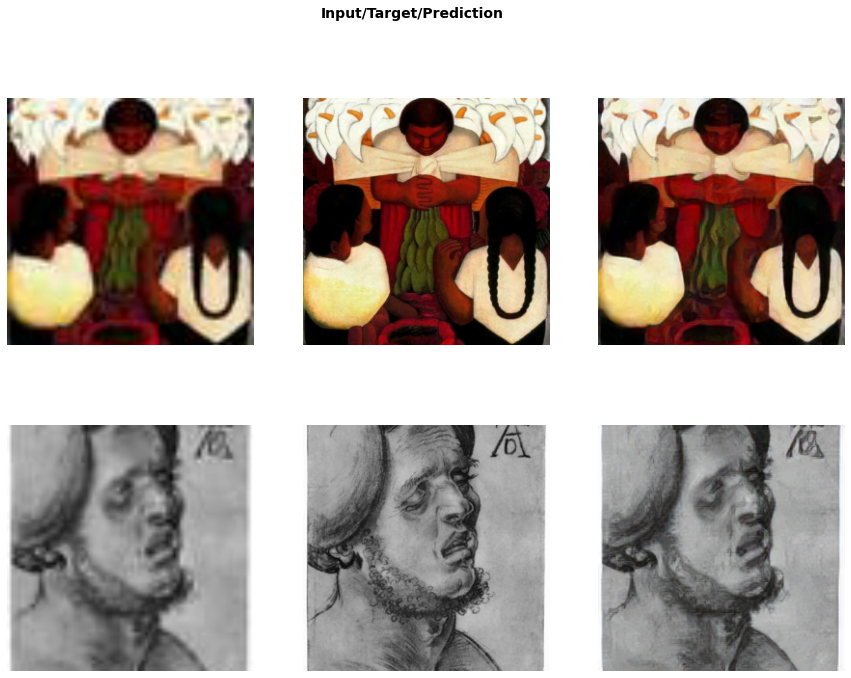

In [23]:
do_fit('super_res_painting_vgg_loss_3')

In [24]:
learn.unfreeze()

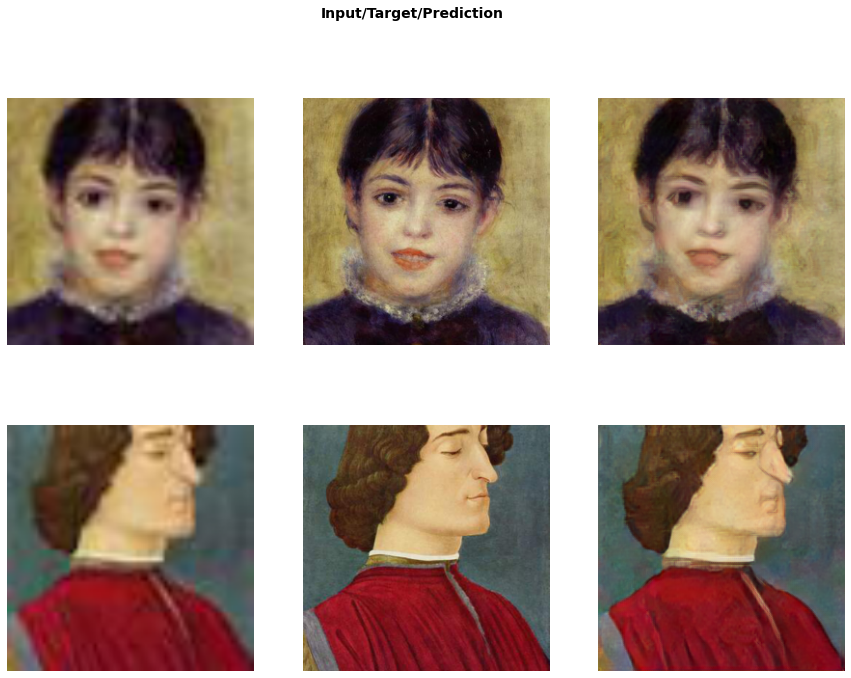

In [25]:
do_fit('super_res_painting_vgg_loss_4', slice(1e-6,1e-4), pct_start=0.3)

In [ ]:
learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

## Test

In [ ]:
dls = get_dls(1,size)
loaded_learn = unet_learner(dls, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                     blur=True, norm_type=NormType.Weight)
dls = get_dls(1,size * 2)
loaded_learn.dls = dls

In [ ]:
loaded_learn.load('super_res_painting_vgg_loss_4_' + str(now));
loaded_learn.cuda()

In [ ]:
loaded_learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(428, 512)
(256, 256)


<AxesSubplot:>

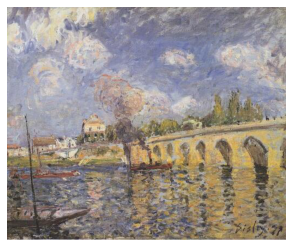

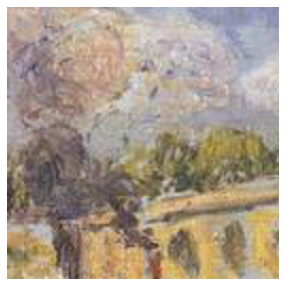

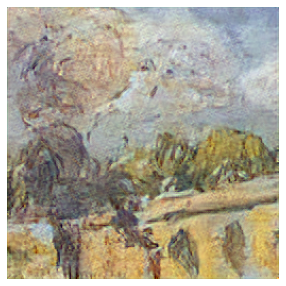

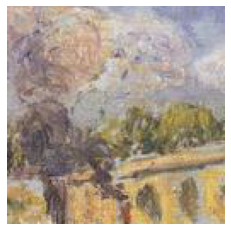

In [107]:
import glob
import torchvision.transforms as T
import random

ORIGINAL_PATH = Path('/home/lleonard/Documents/datasets/best_art/images/images/')


files = glob.glob(str(DATASET_PATH) + '/**/*.jpg')
random_idx = random.randint(0, len(files) - 1)

image = PILImage.create(files[random_idx])
original_image = PILImage.create(ORIGINAL_PATH / Path(files[random_idx]).parent /  Path(files[random_idx]).name)

show_image(original_image)
print(image.shape)

part_size = 128
w, h = image.size
upscaled_image = image.crop((w/2-(part_size / 2), h/2-(part_size / 2),w/2+(part_size / 2), h/2+(part_size / 2))) \
.resize((256,256))

#convert to fastai image type
image = PILImage.create(np.array(upscaled_image.convert('RGB')))

show_image(image)
print(image.shape)


img_hr,*_ = learn.model(ToTensor()(image).unsqueeze(0).float().cuda() / 255.)
show_image(img_hr)

show_image(original_image.crop((w/2-(part_size / 2), h/2-(part_size / 2),w/2+(part_size / 2), h/2+(part_size / 2))) \
           )

In [108]:
torch.save({'model': learn.model}, './super_res_painting_self_attention_spectral.pth')